In [2]:
%kaggle competitions download -c histopathologic-cancer-detection

UsageError: Line magic function `%kaggle` not found.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import os
import cv2

import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, BatchNormalization, Activation
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_auc_score, accuracy_score
from PIL import Image
from keras.optimizers import Adam

path = r"C:\Users\sasan\Downloads\hist_cancer\\"
%cd "C:\Users\sasan\Downloads\hist_cancer"
%ls

C:\Users\sasan\Downloads\hist_cancer
 Volume in drive C is Acer
 Volume Serial Number is 4C88-CF93

 Directory of C:\Users\sasan\Downloads\hist_cancer

04/06/2023  12:07 PM    <DIR>          .
04/20/2023  11:53 AM    <DIR>          ..
04/06/2023  12:07 PM         2,470,703 sample_submission.csv
04/05/2023  09:11 PM    <DIR>          test
04/05/2023  11:08 PM    <DIR>          train
04/06/2023  12:03 PM         9,461,084 train_labels.csv
               2 File(s)     11,931,787 bytes
               4 Dir(s)  72,835,543,040 bytes free


In [6]:
labels_df = pd.read_csv(path+'train_labels.csv')
labels_df['id'] = labels_df['id'] + '.tif'
labels_df['label'] = labels_df['label'].astype(str)
print(labels_df.head().to_markdown())
print(labels_df.shape)

|    | id                                           |   label |
|---:|:---------------------------------------------|--------:|
|  0 | f38a6374c348f90b587e046aac6079959adf3835.tif |       0 |
|  1 | c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif |       1 |
|  2 | 755db6279dae599ebb4d39a9123cce439965282d.tif |       0 |
|  3 | bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif |       0 |
|  4 | 068aba587a4950175d04c680d38943fd488d6a9d.tif |       0 |
(220025, 2)


In [7]:
# Checking duplicates, none found
labels_df[labels_df.duplicated(keep=False)]

,id,label


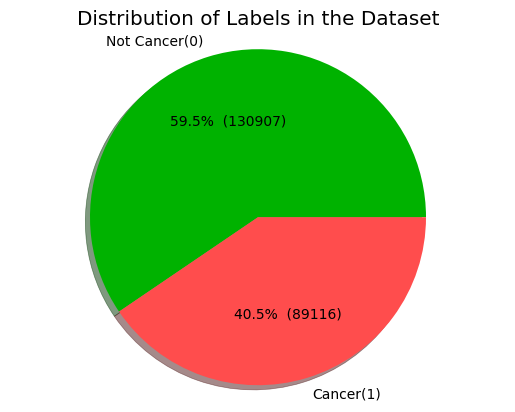

In [9]:
labels_count = labels_df.label.value_counts()

plt.pie(labels_count, labels=['Not Cancer(0)', 'Cancer(1)'], startangle=0,
        autopct=lambda pct: f'{pct:.1f}%  ({int(pct/100*sum(labels_count))})',
        colors=['#00B200', '#ff4d4d'], shadow=True)

plt.axis('equal')
plt.title('Distribution of Labels in the Dataset')
plt.show()

(96, 96, 3)


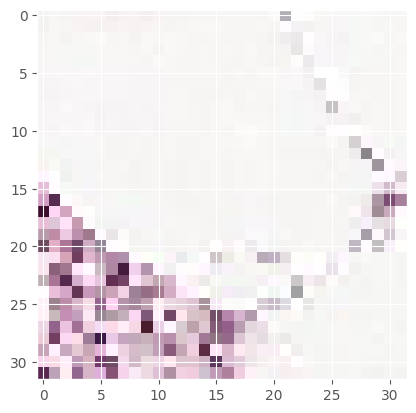

In [10]:
# Read an image file
img = cv2.imread(path+'/train/'+labels_df.iloc[0,0])
print(img.shape)
# Resize the image
resized = cv2.resize(img, (32, 32))

# Display the resized image
plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))

In [11]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    
    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(3*figure_cols,3*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

TypeError: Image data of dtype object cannot be converted to float

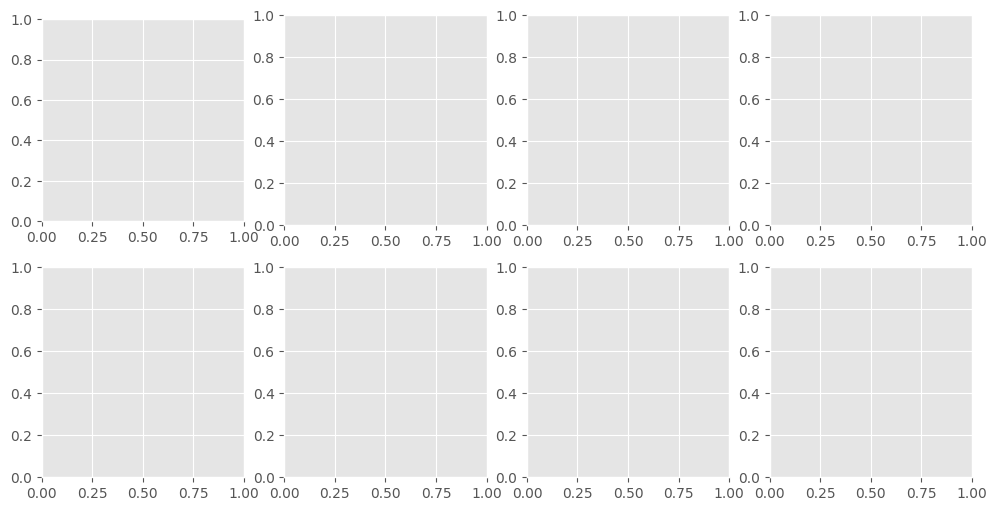

In [12]:
IMAGE_PATH = path+'/train/' 

draw_category_images('label',4, labels_df, IMAGE_PATH)

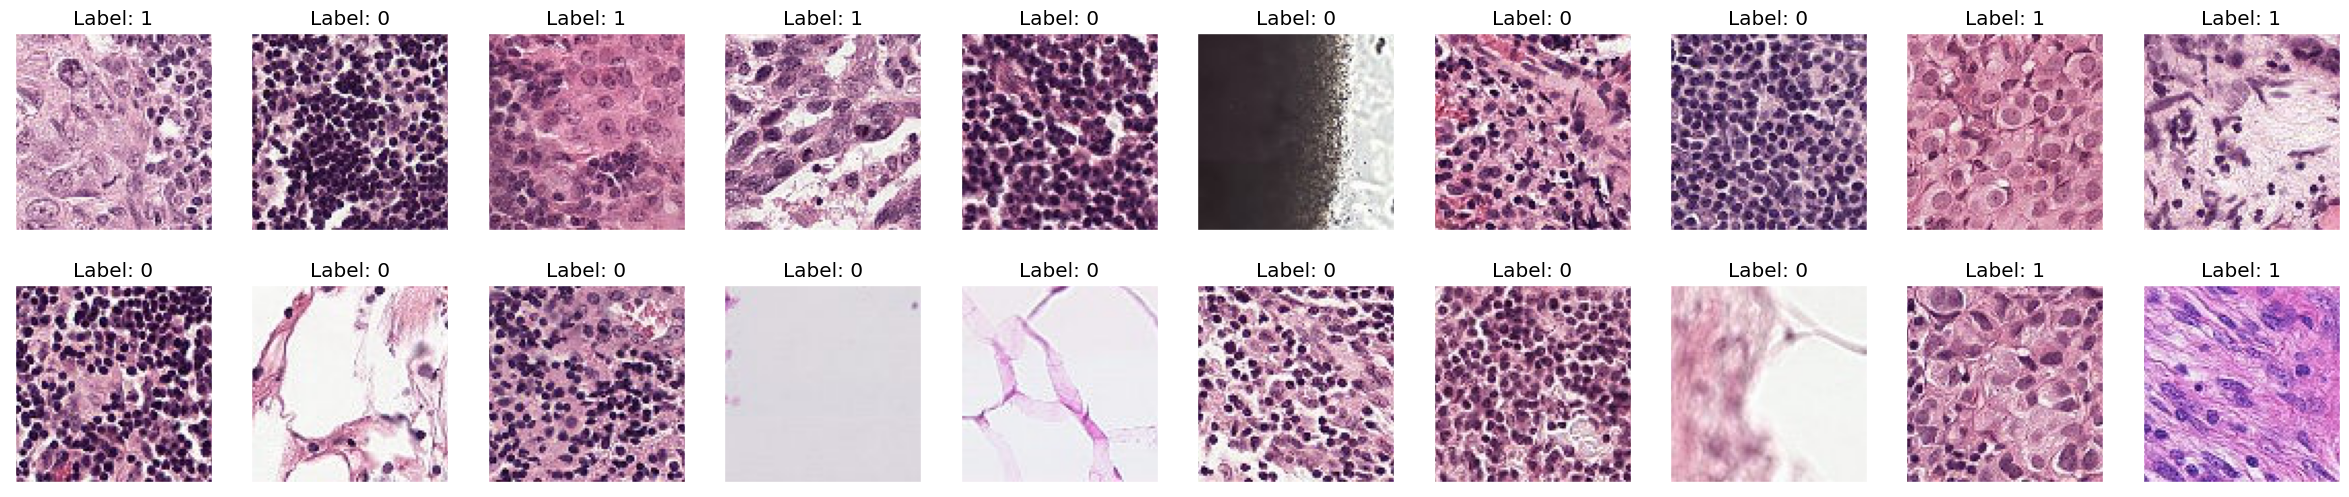

In [13]:
fig = plt.figure(figsize=(30, 6))

# display 20 images
train_imgs = os.listdir(path+"train")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(path+"train/" + img)
    plt.imshow(im)
    lab = labels_df.loc[labels_df['id'] == img, 'label'].values[0]
    ax.set_title('Label: %s'%lab)

In [15]:

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

batch_size = 256

model.build(input_shape=(batch_size, 48, 48, 3))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (256, 46, 46, 16)         448       
                                                                 
 conv2d_5 (Conv2D)           (256, 44, 44, 16)         2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (256, 22, 22, 16)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (256, 20, 20, 32)         4640      
                                                                 
 conv2d_7 (Conv2D)           (256, 18, 18, 32)         9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (256, 9, 9, 32)          0         
 2D)                                                  

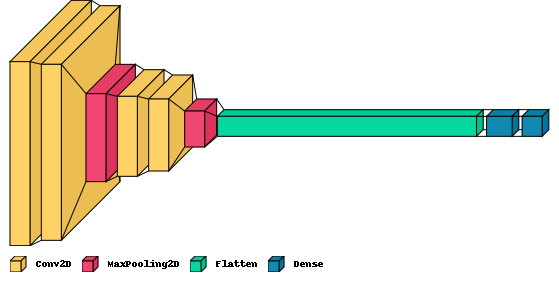

In [16]:
#os.system('pip install visualkeras')
import visualkeras
visualkeras.layered_view(model, legend=True)

In [17]:
IMAGE_PATH = path+'/train/' 

generator = ImageDataGenerator(rescale=1./255, validation_split=0.25)

data_train = generator.flow_from_dataframe(
    dataframe = labels_df,
    x_col='id', # filenames
    y_col='label', # labels
    directory=IMAGE_PATH,
    subset='training',
    class_mode='binary',
    batch_size=batch_size,
    target_size=(48, 48))

data_validate=generator.flow_from_dataframe(
    dataframe=labels_df,
    x_col='id', # filenames
    y_col='label', # labels
    directory=IMAGE_PATH,
    subset="validation",
    class_mode='binary',
    batch_size=batch_size,
    target_size=(48, 48))

Found 165019 validated image filenames belonging to 2 classes.
Found 55006 validated image filenames belonging to 2 classes.


In [18]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

hist = model.fit(data_train, validation_data=data_validate, epochs=10)

Epoch 1/10
645/645 [==============================] - 1594s 2s/step - loss: 0.4776 - accuracy: 0.7747 - val_loss: 0.4305 - val_accuracy: 0.8048
Epoch 2/10
645/645 [==============================] - 1520s 2s/step - loss: 0.4059 - accuracy: 0.8192 - val_loss: 0.3641 - val_accuracy: 0.8413
Epoch 3/10
645/645 [==============================] - 1298s 2s/step - loss: 0.3619 - accuracy: 0.8412 - val_loss: 0.4018 - val_accuracy: 0.8146
Epoch 4/10
645/645 [==============================] - 1528s 2s/step - loss: 0.3384 - accuracy: 0.8534 - val_loss: 0.3169 - val_accuracy: 0.8640
Epoch 5/10
645/645 [==============================] - 1479s 2s/step - loss: 0.3198 - accuracy: 0.8628 - val_loss: 0.3185 - val_accuracy: 0.8632
Epoch 6/10
645/645 [==============================] - 1359s 2s/step - loss: 0.3057 - accuracy: 0.8701 - val_loss: 0.3046 - val_accuracy: 0.8733
Epoch 7/10
645/645 [==============================] - 1348s 2s/step - loss: 0.2897 - accuracy: 0.8777 - val_loss: 0.2873 - val_accuracy:

In [34]:
%cd "C:\Users\sasan\OneDrive\Desktop\hist_cancer"

C:\Users\sasan\OneDrive\Desktop\hist_cancer


In [ ]:
# import h5py

# model.save("my_model.h5")

# loaded_model = load_model("my_model.h5")

# # Load the model
# loaded_model = load_model(r"C:\Users\sasan\OneDrive\Desktop\hist_cancer\CNN_accurate.h5")

# # Compile the model with the same optimizer, loss function, and metrics as during training
# loaded_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Load the saved weights into the model
# loaded_model.load_weights(r"C:\Users\sasan\OneDrive\Desktop\hist_cancer\CNN_accurate_weights.h5")

# # Print the model summary
# loaded_model.summary()



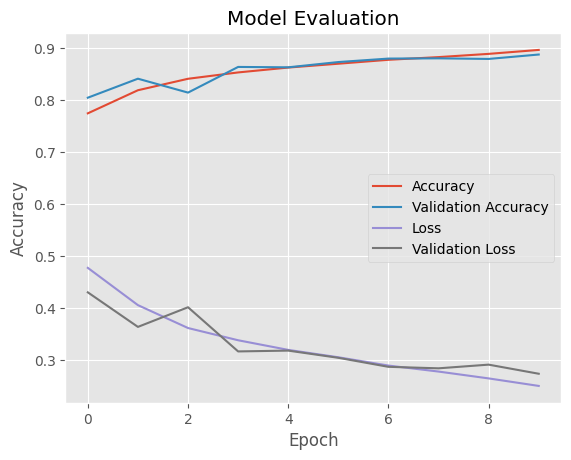

In [31]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.title("Model Evaluation")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])

plt.show()

In [41]:
test_path = path+'\\test\\'
images_test = pd.DataFrame({'id':os.listdir(test_path)})

generator_testing = ImageDataGenerator(rescale=1./255)

data_test = generator_testing.flow_from_dataframe(
    dataframe = images_test,
    x_col='id', 
    directory=test_path,
    class_mode=None,
    batch_size=1,
    target_size=(48, 48),
    shuffle=False)

Found 57458 validated image filenames.


In [42]:
predictions = model.predict(data_test, verbose=1)
print(predictions)

57458/57458 [==============================] - 372s 6ms/step
[[0.98275894]
 [0.87168735]
 [0.6683039 ]
 ...
 [0.00161249]
 [0.9571296 ]
 [0.05424174]]


In [44]:
pd.DataFrame(predictions).to_csv("predictions_values.csv")

##    VGG 16

In [ ]:
base_model = tf.keras.applications.VGG16(
    input_shape=(im_size[0],im_size[1],3), 
    include_top=False, 
    weights='imagenet'
)

#color_map = get_color_map()
visualkeras.layered_view(base_model, color_map=color_map, legend=True)

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)
model_vgg16 = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
], name='vgg16_backbone')
model_vgg16.summary()

In [ ]:
opt = tf.keras.optimizers.Adam(0.001)
base_model.trainable = False
model_vgg16.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])

In [ ]:
hist = model_vgg16.fit(train_data, epochs = 20, validation_data = val_data, verbose=1)

In [ ]:
import pickle
from IPython.display import FileLink


# save the model to a file
with open('model.pkl', 'wb') as f:
    pickle.dump(hist, f)

# output the file to Kaggle Output
FileLink('model.pkl')